# Sequential A/B Testing

## Alpha-Spending
O'Brien-Fleming Method: calculates the alpha threshold for a given interim analysis point. This method provides more stringent alpha control early in the experiment and relaxes as more data becomes available.

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def obrien_fleming(spending_time, total_time=1.0, alpha=0.05):
    """ Calculate alpha threshold at a given time using O'Brien-Fleming method """
    return (alpha * (stats.norm.ppf(1 - alpha) / stats.norm.ppf(1 - alpha * spending_time / total_time))**2)

# Points in time when the interim analyses are performed (fraction of total data collected)
analysis_points = [0.25, 0.5, 0.75, 1.0]
total_alpha = 0.05
alpha_thresholds = [obrien_fleming(point, total_time=1.0, alpha=total_alpha) for point in analysis_points]

# Example observed p-values from interim analyses
observed_p_values = [0.049, 0.045, 0.025, 0.01]

for point, alpha, p in zip(analysis_points, alpha_thresholds, observed_p_values):
    print(f"Analysis at {point*100}% data:")
    print(f"\tAlpha threshold = {alpha:.4f}")

    # Decisions based on alpha-spending
    decision = "Reject H0" if p <= alpha else "Do not reject H0"
    print(f"\tp-value = {p}")
    print(f"\tDecision: {decision}\n")

Analysis at 25.0% data:
	Alpha threshold = 0.0269
	p-value = 0.049
	Decision: Do not reject H0

Analysis at 50.0% data:
	Alpha threshold = 0.0352
	p-value = 0.045
	Decision: Do not reject H0

Analysis at 75.0% data:
	Alpha threshold = 0.0427
	p-value = 0.025
	Decision: Reject H0

Analysis at 100.0% data:
	Alpha threshold = 0.0500
	p-value = 0.01
	Decision: Reject H0



## Canary Testing (Continuous Data)
The Netflix team published a great blog post summarizing their paper on sequential A/B testing. I recreated some of their work here to better understand it.

They perform A/B tests for new software releases that control for Type-I error across all quantiles of the data distributions.

Sources:
- [Netflix blog](https://netflixtechblog.com/sequential-a-b-testing-keeps-the-world-streaming-netflix-part-1-continuous-data-cba6c7ed49df) on sequential A/B testing.
- [Rapid Regression Detection in Software Deployments through Sequential Testing](https://arxiv.org/pdf/2205.14762)
- [Sequential estimation of quantiles with applications to A/B testing and best-arm identification](https://arxiv.org/pdf/1906.09712)

Sequential statistical tests are "anytime valid", meaning that they permit peeking and can be applied each time a new data point comes in.

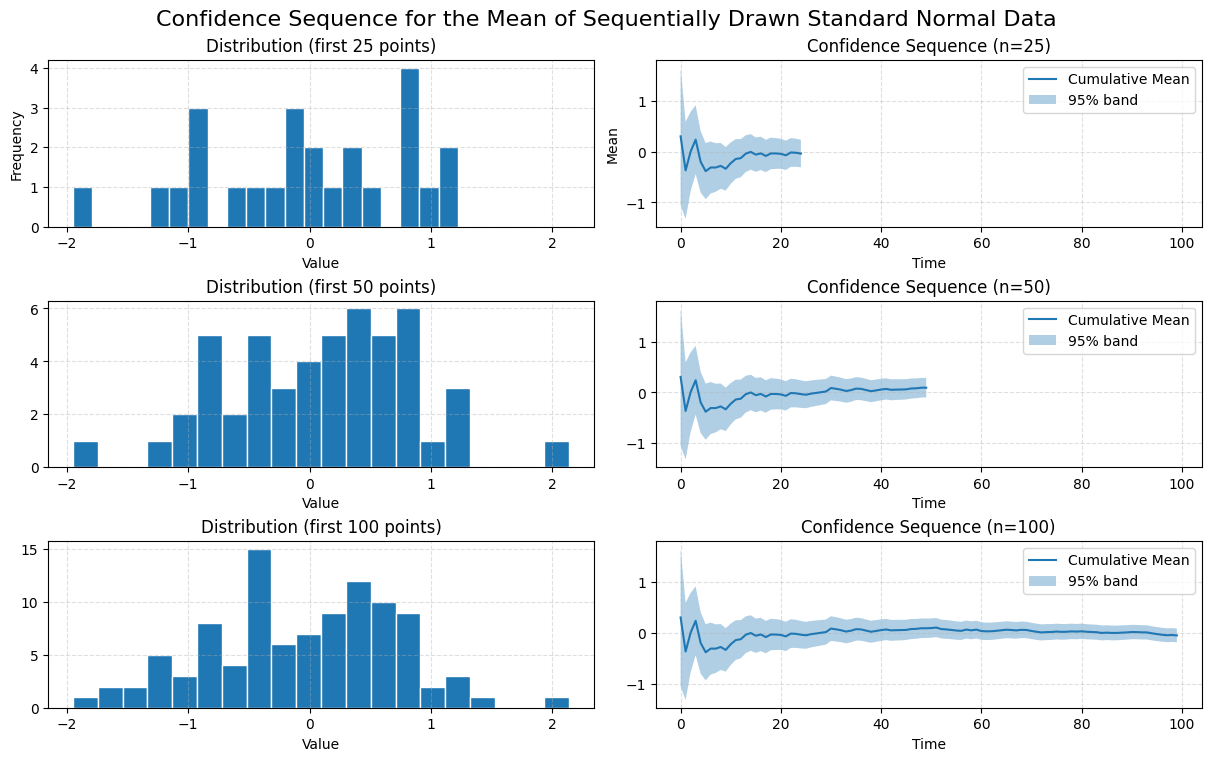

In [ ]:
def confidence_sequence(data: np.ndarray, alpha: float = 0.05) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Computes an anytime-valid confidence sequence for the mean using Hoeffding's inequality.

    Args:
        data: Array of sequential data points.
        alpha: Two-sided error rate

    Returns:
        Tuple containing:
        - mean: Running mean at each time step.
        - lower_bound: Lower bound of the confidence band.
        - upper_bound: Upper bound of the confidence band.
    """
    t = np.arange(1, data.size + 1)
    mean = np.cumsum(data) / t
    bound = np.sqrt(np.log(2 / alpha) / (2 * t))
    return mean, mean - bound, mean + bound


rng = np.random.default_rng(seed=42)
data = rng.standard_normal(100)

timesteps = [25, 50, 100]
fig, axes = plt.subplots(nrows=len(timesteps),
                         ncols=2,
                         figsize=(12, 2.5 * len(timesteps)),
                         sharex='col',
                         constrained_layout=True)
fig.suptitle('Confidence Sequence for the Mean of Sequentially Drawn Standard Normal Data', fontsize=16)


for row, t in enumerate(timesteps):
    subset = data[:t]
    mean, lb, ub = confidence_sequence(subset)

    # Histogram
    ax_h = axes[row, 0]
    ax_h.hist(subset, bins=20, color='tab:blue', edgecolor='white')
    ax_h.set_title(f'Distribution (first {t} points)', fontsize=12)
    ax_h.set_xlabel('Value')
    ax_h.set_ylabel('Frequency' if row == 0 else '')   # avoid clutter
    ax_h.tick_params(bottom=True, labelbottom=True)
    ax_h.grid(True, linestyle='--', alpha=0.4)

    # Confidence sequence
    ax_c = axes[row, 1]
    ax_c.plot(mean, label='Cumulative Mean', lw=1.5)
    ax_c.fill_between(np.arange(t), lb, ub, alpha=0.35, label='95% band')
    ax_c.set_title(f'Confidence Sequence (n={t})', fontsize=12)
    ax_c.set_xlabel('Time')
    ax_c.set_ylabel('Mean' if row == 0 else '')
    ax_c.tick_params(bottom=True, labelbottom=True)
    ax_c.legend()
    ax_c.grid(True, linestyle='--', alpha=0.4)


plt.show()

If the confidence bands around the EQF difference exclude 0 at certain quantiles, there is strong evidence of a distributional difference (e.g., increased delays at certain percentiles).

Here, the treatment and control have the same mean (0), but the treatment has a standard deviation of 1.5 and the control has a standard deviation of 1.

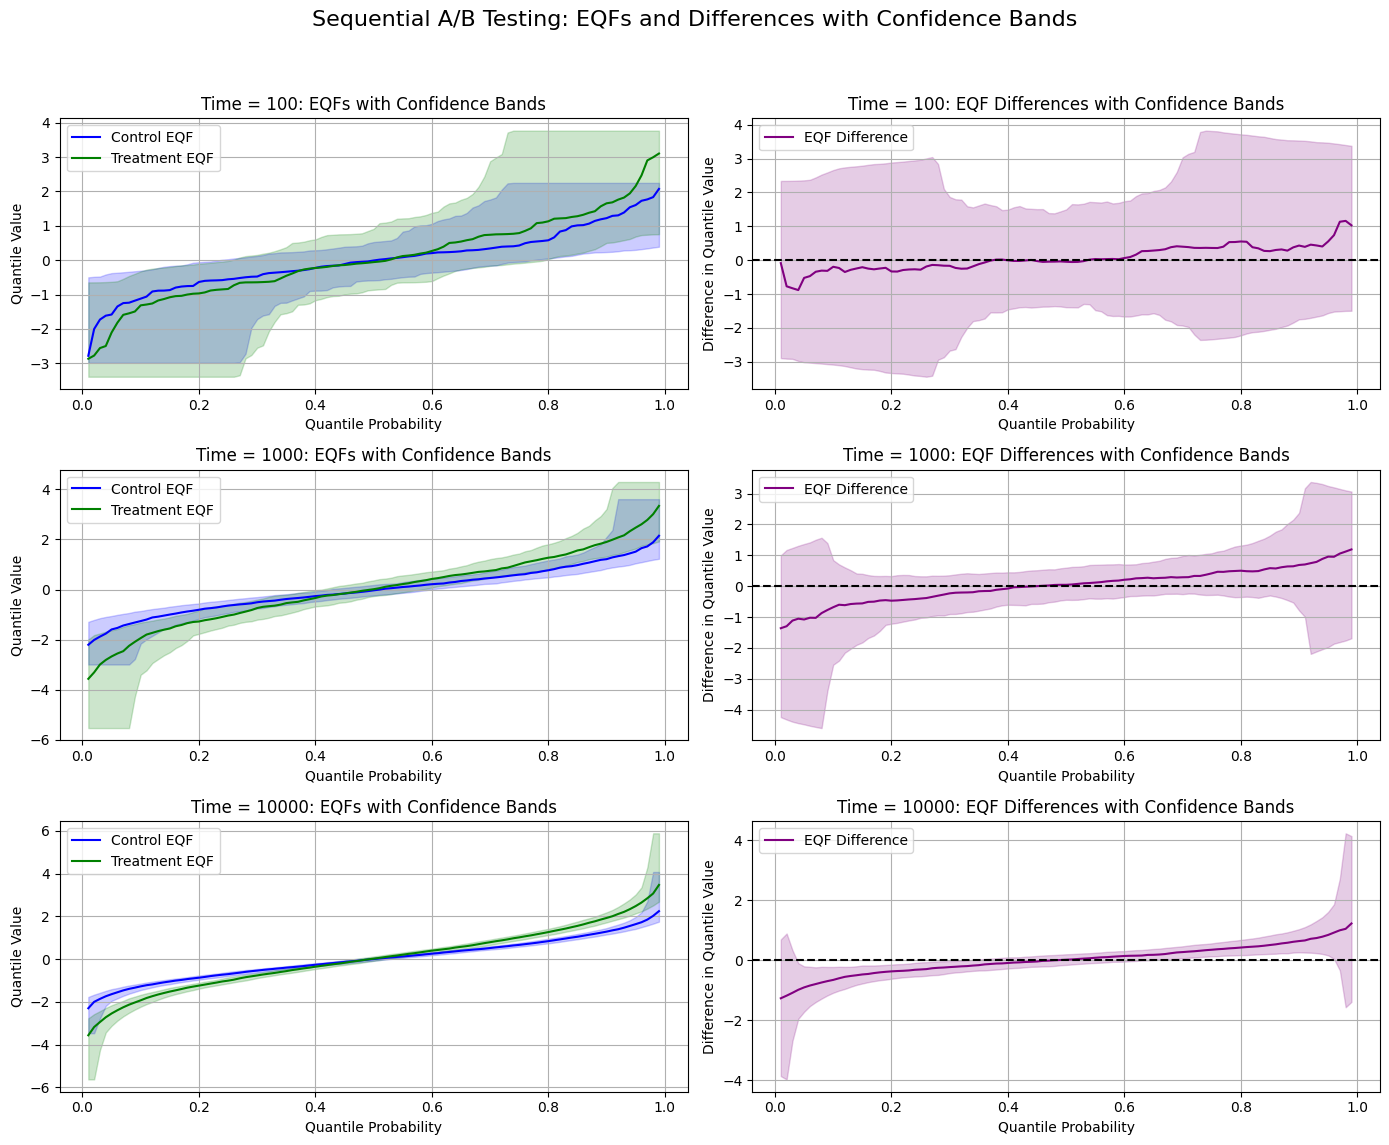

In [21]:
def confidence_band(t, alpha=0.05):
    """
    Computes the width of the confidence band for empirical quantile functions,
    based on Howard & Ramdas (2022).

    Args:
        t: Sample size at time t.
        alpha: Significance level for the confidence band.

    Returns:
        The width of the confidence band.
    """
    # This comes from Corollary 2 in Howard & Ramdas (2022)
    if not (0 < alpha < 0.25):
        raise TypeError("Alpha must be an between (0, 0.25). Got alpha={alpha}")
    
    # C is a tuning constant that controls the probability guarantee of the confidence sequence.
    C = 0.8 * np.log(1612 / alpha)
    
    return 0.85 * np.sqrt((np.log(np.log(np.e * t)) + C) / t)

def compute_eqf_with_bands(data, quantiles, u_t):
    """
    Computes empirical quantile function and its confidence bands.

    Args:
        data: 1D array of data points.
        quantiles: Array of quantile probabilities.
        u_t: Width of the confidence band.

    Returns:
        Tuple of (quantiles, lower_band, upper_band).
    """
    q = np.quantile(data, quantiles)
    lower = np.quantile(data, np.clip(quantiles - u_t, 0, 1))
    upper = np.quantile(data, np.clip(quantiles + u_t, 0, 1))
    return q, lower, upper


# Params
t_values = [100, 1000, 10000]
quantiles = np.linspace(0.01, 0.99, 99)
alpha = 0.05

# Generate synthetic data
max_t = max(t_values)
control_data = rng.normal(loc=0, scale=1, size=max_t)
treatment_data = rng.normal(loc=0, scale=1.5, size=max_t)

# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
fig.suptitle('Sequential A/B Testing: EQFs and Differences with Confidence Bands', fontsize=16)

for idx, t in enumerate(t_values):
    u_t = confidence_band(t, alpha=alpha)
    control_q, control_lower, control_upper = compute_eqf_with_bands(control_data[:t], quantiles, u_t)
    treatment_q, treatment_lower, treatment_upper = compute_eqf_with_bands(treatment_data[:t], quantiles, u_t)
    
    # Plot EQFs
    ax_eqf = axes[idx, 0]
    ax_eqf.plot(quantiles, control_q, label='Control EQF', color='blue')
    ax_eqf.fill_between(quantiles, control_lower, control_upper, color='blue', alpha=0.2)
    ax_eqf.plot(quantiles, treatment_q, label='Treatment EQF', color='green')
    ax_eqf.fill_between(quantiles, treatment_lower, treatment_upper, color='green', alpha=0.2)
    ax_eqf.set_title(f'Time = {t}: EQFs with Confidence Bands')
    ax_eqf.set_xlabel('Quantile Probability')
    ax_eqf.set_ylabel('Quantile Value')
    ax_eqf.legend()
    ax_eqf.grid(True)

    # Plot EQF Differences
    ax_diff = axes[idx, 1]
    eqf_diff = treatment_q - control_q
    diff_lower = treatment_lower - control_upper
    diff_upper = treatment_upper - control_lower
    ax_diff.plot(quantiles, eqf_diff, label='EQF Difference', color='purple')
    ax_diff.fill_between(quantiles, diff_lower, diff_upper, color='purple', alpha=0.2)
    ax_diff.axhline(y=0, color='black', linestyle='--')
    ax_diff.set_title(f'Time = {t}: EQF Differences with Confidence Bands')
    ax_diff.set_xlabel('Quantile Probability')
    ax_diff.set_ylabel('Difference in Quantile Value')
    ax_diff.legend()
    ax_diff.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()